# Assignment 1: 1-Layer Neural Network Image Classification

## Libraries and Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Data

In [2]:
# download data
import tarfile
import urllib.request
import os
import shutil

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = "cifar-10-python.tar.gz"
DATA_PATH = "Datasets/"

if not os.path.exists(DATA_PATH):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.rename("cifar-10-batches-py", DATA_PATH)
    os.remove(filename)

In [3]:
"""
Alex Krizhevzky's pickle function for expanding the data for training a model
on cifar-10.
Source: https://www.cs.toronto.edu/~kriz/cifar.html
"""


def unpickle(file):
    import pickle

    with open(DATA_PATH + file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [4]:
"""
Display the image data.
"""


def display_image_data(X, y, num_images=5):
    X_display = X[:, :num_images]
    X_im = X_display.reshape((32, 32, 3, num_images), order="F")
    X_im = np.transpose(X_im, (1, 0, 2, 3))

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(X_im[:, :, :, i])
        axs[i].set_title(f"Class: {y[i]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

## Exercise 1 - Training a multi-linear classifier

### 1.1 - Load Data

In [5]:
"""
Load the data for building the neural network.

Return:
  X - contains the image pixel data. Size d x n
  d - the dimensionality of each image: 3072 (32 x 32 x 3)
  n - number of images = 10000

  Y - the one hot representation of the label for each image. Size k x n
  k - the number of labels = 10
  n - number of images = 10000

  y - vector of length n containing the label for each image. Size n x 1
  n - number of images = 10000
  cifar-10 encodes the labels as integers between 0-9.
"""


def load_batch(filename):
    dict = unpickle(filename)
    X = dict[b"data"].astype(np.float64) / 255.0
    X = X.transpose()
    y = np.array(dict[b"labels"])
    Y = np.zeros((10, y.shape[0]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1

    return X, Y, y

In [6]:
print(f"load training data...")
raw_input_X_train, Y_train_labels, y_train_actual_labels = load_batch(
    "data_batch_1"
)

print(f"X train dimensions -> {raw_input_X_train.shape}\n")
print(f"Y train dimensions -> {Y_train_labels.shape}\n")
print(f"y train dimensions -> {y_train_actual_labels.shape}\n")

load training data...
X train dimensions -> (3072, 10000)

Y train dimensions -> (10, 10000)

y train dimensions -> (10000,)



/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_13181/2074111963.py:12: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding="bytes")


In [7]:
print(f"load validation data...")
raw_input_X_valid, Y_valid_labels, y_valid_actual_labels = load_batch(
    "data_batch_2"
)

print(f"X validation dimensions: {raw_input_X_valid.shape}\n")
print(f"Y validation dimensions: {Y_valid_labels.shape}\n")
print(f"y validation dimensions: {y_valid_actual_labels.shape}\n")

load validation data...


/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_13181/2074111963.py:12: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding="bytes")


X validation dimensions: (3072, 10000)

Y validation dimensions: (10, 10000)

y validation dimensions: (10000,)



In [8]:
print(f"load test data...")
raw_input_X_test, Y_test_labels, y_test_actual_labels = load_batch(
    "test_batch"
)

print(f"X test dimensions: {raw_input_X_test.shape}\n")
print(f"Y test dimensions: {Y_test_labels.shape}\n")
print(f"y test dimensions: {y_test_actual_labels.shape}\n")

load test data...


/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_13181/2074111963.py:12: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding="bytes")


X test dimensions: (3072, 10000)

Y test dimensions: (10, 10000)

y test dimensions: (10000,)



display training data with classes...


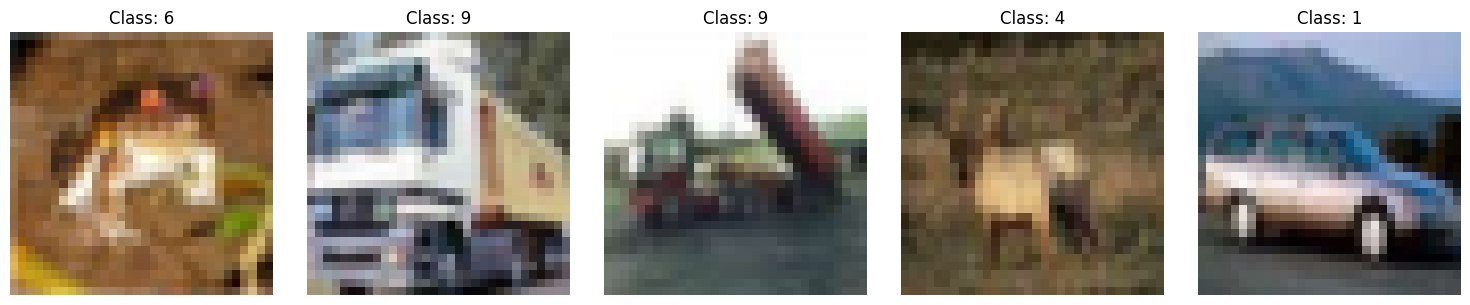

In [9]:
print(f"display training data with classes...")
display_image_data(raw_input_X_train, y_train_actual_labels)

display validation data with classes...


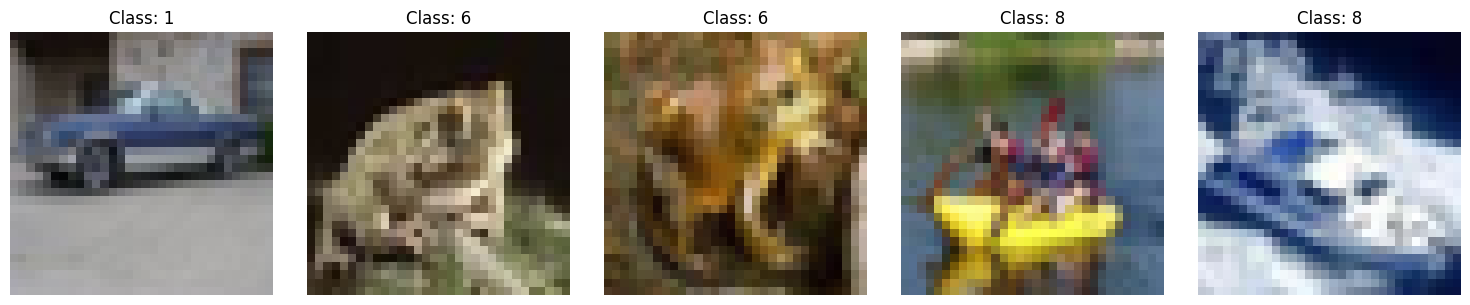

In [10]:
print(f"display validation data with classes...")
display_image_data(raw_input_X_valid, y_valid_actual_labels)

display test data with classes...


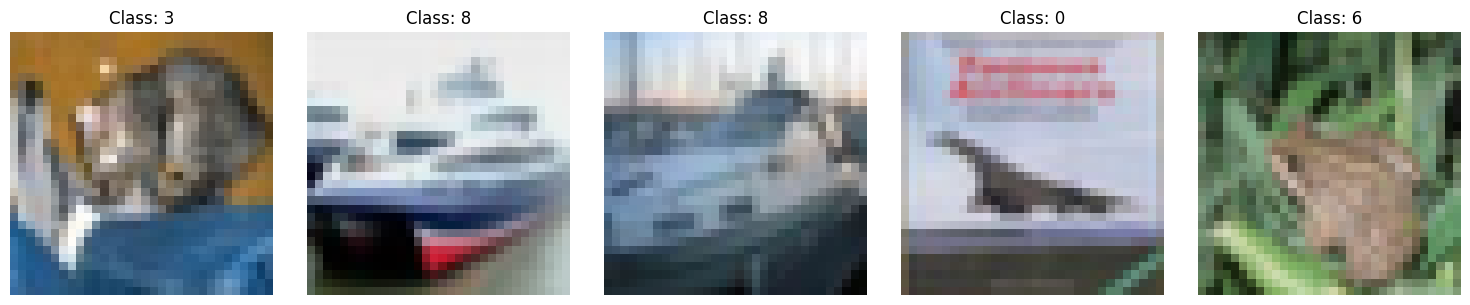

In [11]:
print(f"display test data with classes...")
display_image_data(raw_input_X_test, y_test_actual_labels)

### 1.2 - Preprocess Data

In [12]:
"""
Preprocess data.

Return:
  transform the data so that it has zero mean
"""


def preprocess_data(X_train, X_valid, X_test):
    mean_X = np.mean(X_train, axis=1).reshape(-1, 1)
    std_X = np.std(X_train, axis=1).reshape(-1, 1)

    norm_X_train = (X_train - mean_X) / std_X
    norm_X_valid = (X_valid - mean_X) / std_X
    norm_X_test = (X_test - mean_X) / std_X

    return norm_X_train, norm_X_valid, norm_X_test

In [13]:
print("raw input data...")
print(f"raw X training data[0] -> {raw_input_X_train[0]}\n")
print(f"raw X validation data[0] -> {raw_input_X_valid[0]}\n")
print(f"raw X testing data[0] -> {raw_input_X_test[0]}\n")

raw input data...
raw X training data[0] -> [0.23137255 0.60392157 1.         ... 0.27843137 0.98039216 0.24313725]

raw X validation data[0] -> [0.1372549  0.07843137 0.45490196 ... 0.49803922 0.74509804 0.69411765]

raw X testing data[0] -> [0.61960784 0.92156863 0.61960784 ... 0.07843137 0.09803922 0.28627451]



In [14]:
print(f"pre-process input data...")
norm_X_train, norm_X_valid, norm_X_test = preprocess_data(
    raw_input_X_train, raw_input_X_valid, raw_input_X_test
)

print(f"pre-processed X trainining data[0]: {norm_X_train[0]}\n")
print(f"pre-processed X validation data[0]: {norm_X_valid[0]}\n")
print(f"pre-processed X testing data[0]: {norm_X_test[0]}\n")

pre-process input data...
pre-processed X trainining data[0]: [-0.99022072  0.29827618  1.66815183 ... -0.82746321  1.6003362
 -0.94953134]

pre-processed X validation data[0]: [-1.31573572 -1.5191826  -0.21712258 ... -0.0679282   0.78654869
  0.61022806]

pre-processed X testing data[0]: [ 0.35252868  1.39688932  0.35252868 ... -1.5191826  -1.45136697
 -0.80033696]



### 1.3 - Neural Network Architecture

In [15]:
"""
Initialize the network with random parameters

Return:
  initialized weights and biases for training the model
"""


def initialize_network(k, d, rng):
    init_net = {}
    init_net["W"] = 0.01 * rng.standard_normal(size=(k, d))
    init_net["b"] = np.zeros((k, 1))

    return init_net

In [16]:
def init_network():
    rng = np.random.default_rng()
    BitGen = type(rng.bit_generator)
    seed = 42
    rng.bit_generator.state = BitGen(seed).state
    # W - k x d
    # b - k x 1
    # k - number of labels  = 10
    # d - the dimensionality of each image: 3072 (32 x 32 x 3)
    k = 10
    d = 3072
    init_net = initialize_network(k, d, rng)

    return init_net

In [17]:
debug_init_net = init_network()

print(f"initialize network...")
print(f"w shape -> {debug_init_net['W'].shape}")
print(f"initialized weights -> {debug_init_net['W']}\n")
print(f"b shape -> {debug_init_net['b'].shape}")
print(f"initialized bias -> {debug_init_net['b']}\n")

initialize network...
w shape -> (10, 3072)
initialized weights -> [[ 0.00304717 -0.01039984  0.00750451 ... -0.0084532   0.00859046
   0.00207751]
 [-0.01571098  0.00770699  0.01267624 ...  0.00355376  0.01962006
  -0.00042941]
 [ 0.00953304 -0.00451231 -0.00514599 ...  0.01202027 -0.0141204
   0.02093487]
 ...
 [-0.00392997  0.00902848 -0.00248387 ... -0.00953536  0.00187572
  -0.01632324]
 [ 0.00151578 -0.0027873   0.00180964 ...  0.0041036   0.01396361
  -0.00068254]
 [ 0.00519414 -0.00176759  0.01020552 ...  0.00520489  0.0100142
  -0.01176617]]

b shape -> (10, 1)
initialized bias -> [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]



### 1.4 - Generalization

In [18]:
"""
Activation functions.
"""


# softmax function - not numerically stable according to stanford cs231n notes
def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=0)

In [19]:
"""
Forward pass.

Return:
  the probability matrix containing the preditions of which class each input belongs to
"""


def apply_network(X, network):
    # k x d
    W = network["W"]
    # k x 1
    b = network["b"]

    # each column of X is d x n
    s = W @ X + b

    # P - k x n
    P = softmax(s)

    return P

In [20]:
print(f"compute forward pass...")
init_net = init_network()
P = apply_network(norm_X_train[:, 0:100], init_net)

print(f"test apply network function shape -> {P.shape}\n")
print(f"test apply network[0]: {P[0]}\n")

compute forward pass...
test apply network function shape -> (10, 100)

test apply network[0]: [0.04736468 0.08396028 0.21231548 0.10608764 0.19843278 0.18094819
 0.04417183 0.11146134 0.04870731 0.20728045 0.15013374 0.10578131
 0.09367191 0.21486919 0.12681273 0.11496373 0.06364273 0.10683089
 0.09932954 0.06598358 0.05634004 0.15993752 0.14545062 0.21149704
 0.20606918 0.09383137 0.16933834 0.14796502 0.07442087 0.18042918
 0.13448296 0.14515211 0.23440249 0.05048548 0.09922041 0.11787902
 0.03039725 0.10943543 0.08439578 0.09415008 0.09536802 0.0214778
 0.04281401 0.15198187 0.26870978 0.12429311 0.03629201 0.15265406
 0.0134772  0.03497963 0.11313109 0.04572599 0.03809661 0.03515325
 0.09296645 0.06375733 0.06682856 0.2012813  0.08421323 0.2855134
 0.25110819 0.05657963 0.10500086 0.19352372 0.11255412 0.11232015
 0.08235042 0.10718864 0.10368239 0.16055633 0.1970895  0.12113645
 0.11074125 0.13216672 0.03971747 0.08645694 0.0602865  0.06078401
 0.06381511 0.0382665  0.08547782 0.

### 1.5 - Loss Function

In [21]:
"""
Compute the cross entropy loss for a set of images.
each column of P is the probability of each class for the corresponding
column of the data X and has size k x n

k - number of labels  = 10
n - number of images = 10000

y is 1 x n and corresponds to the ground truth label of each image whose
predicted labels are contained in P

L - scalar corresponding to the mean cross-entropy loss of the networks predictions
relative to the ground truth labels
"""


def compute_loss(P, y):
    # P - k x n
    n = P.shape[1]

    log_probs = -np.log(P[y, np.arange(n)])
    L = np.sum(log_probs) / n

    return L

In [22]:
"""
Compute cost for a set of images
"""


def compute_cost(P, y, W, lam):
    cross_entropy_loss = compute_loss(P, y)
    cost = cross_entropy_loss + lam * np.sum(W * W)

    return cost

### 1.6 - Accuracy and Prediction

In [23]:
"""
Compute the accuracy of the network's predictions.
accuracy of a classifier for a given set of examples is the percentage of examples
for which it ges the corect answer.

each column of P contains the probability of each class for the corresponding column
of the input data matrix X. size k xn

y - the vector of ground truth labels of length n

accuracy - scalar value containing the accuracy
"""


def compute_accuracy(P, y):
    prediction = np.argmax(P, axis=0)
    correct_prediction = np.sum(prediction == y)
    accuracy = correct_prediction / len(y)

    return accuracy

### 1.7 - Mini-Batch Gradient Descent

In [24]:
"""
Check backpropagation gradient results with this function which does
the same calculation with pytorch using auto-differentiation.
"""


def ComputeGradsWithTorch(X, y, network_params, lam=0):
    # torch requires arrays to be torch tensors
    Xt = torch.from_numpy(X)

    # will be computing the gradient w.r.t. these parameters
    W = torch.tensor(network_params["W"], requires_grad=True)
    b = torch.tensor(network_params["b"], requires_grad=True)

    N = X.shape[1]

    scores = torch.matmul(W, Xt) + b
    ## give an informative name to this torch class
    apply_softmax = torch.nn.Softmax(dim=0)

    # apply softmax to each column of scores
    P = apply_softmax(scores)

    ## compute the loss
    loss = torch.mean(-torch.log(P[y, np.arange(N)]))

    # compute the backward pass relative to the loss and the named parameters
    # loss.backward()
    cost = loss + lam * torch.sum(W * W)
    cost.backward()

    # extract the computed gradients and make them numpy arrays
    grads = {}
    grads["W"] = W.grad.numpy()
    grads["b"] = b.grad.numpy()

    return grads

In [25]:
"""
Backward pass aka backpropagation.

Return:
  the gradients of the weights and biases. helps improve model accuracy using the
  gradient descent algorithm and its variations
"""


def backward_pass(X, Y, P, network, lam=0):
    # number of images
    n = X.shape[1]

    # score gradient
    grad_s = P - Y

    # W gradient
    grad_W = (grad_s @ X.T) / n + 2 * lam * network["W"]

    # b gradient
    grad_b = np.mean(grad_s, axis=1, keepdims=True)

    grads = {}
    grads["W"] = grad_W
    grads["b"] = grad_b

    return grads

In [26]:
def small_network():
    d_small = 10
    n_small = 3
    lam = 0
    rng = np.random.default_rng(42)

    # small neural network with random weights and biases
    small_net = {}
    small_net["W"] = 0.01 * rng.standard_normal(size=(10, d_small))
    small_net["b"] = np.zeros((10, 1))

    # data subset
    X_small = norm_X_train[0:d_small, 0:n_small]
    Y_small = Y_train_labels[:, 0:n_small]
    y_small = y_train_actual_labels[0:n_small]

    # forward pass
    P = apply_network(X_small, small_net)

    # compute gradients
    torch_grads = ComputeGradsWithTorch(X_small, y_small, small_net, lam)
    my_grads = backward_pass(X_small, Y_small, P, small_net, lam)

    return torch_grads, my_grads

In [27]:
def absolute_error_check():
    eps = 1e-6
    torch_grads, my_grads = small_network()
    absolute_error_W = abs(my_grads["W"] - torch_grads["W"])
    absolute_error_b = abs(my_grads["b"] - torch_grads["b"])
    
    print(f"absolute error w gradients -> {np.all(absolute_error_W < eps)}")
    print(f"absolute error b gradients -> {np.all(absolute_error_b < eps)}\n")

In [28]:
def relative_error_check():
    eps = 1e-6
    torch_grads, my_grads = small_network()
    relative_error_W = abs(my_grads["W"] - torch_grads["W"]) / np.maximum(
        eps, abs(my_grads["W"]) + abs(torch_grads["W"])
    )
    relative_error_b = abs(my_grads["b"] - torch_grads["b"]) / np.maximum(
        eps, abs(my_grads["b"]) + abs(torch_grads["b"])
    )

    print(f"relative error w gradients -> {np.all(relative_error_W < eps)}")
    print(f"relative error b gradients -> {np.all(relative_error_b < eps)}")

In [29]:
absolute_error_check()

absolute error w gradients -> True
absolute error b gradients -> True



In [30]:
relative_error_check()

relative error w gradients -> True
relative error b gradients -> True


### 1.8 - Neural Networks go brrrrr......

In [31]:
"""
Train the network using mini-batch gradient descent.
"""


def mini_batch_gd(X, Y, y, X_val, y_val, GDparams, init_net, rng):
    # Deep copy to avoid modifying the original network
    trained_net = copy.deepcopy(init_net)
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    lam = GDparams["lam"]
    # dimensions - number of images = 10000
    n = X.shape[1]

    # record intermediary results
    ## loss
    train_loss_output = []
    valid_loss_output = []
    ## cost
    train_cost_output = []
    valid_cost_output = []
    ## accuracy
    train_acc_output = []
    valid_acc_output = []

    # training loop
    for epoch in range(n_epochs):
        # shuffle training data
        shuffle_indices = rng.permutation(n)
        X_shuffled = X[:, shuffle_indices]
        Y_shuffled = Y[:, shuffle_indices]
        y_shuffled = y[shuffle_indices]

        # mini batch processing
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            X_batch = X_shuffled[:, j_start:j_end]
            Y_batch = Y_shuffled[:, j_start:j_end]

            # forward pass
            P_batch = apply_network(X_batch, trained_net)

            # backward pass
            grad_batch = backward_pass(
                X_batch, Y_batch, P_batch, trained_net, lam
            )

            # update parameters
            trained_net["W"] -= eta * grad_batch["W"]
            trained_net["b"] -= eta * grad_batch["b"]

        # compute metrics after each epoch
        # training metrics
        P_train = apply_network(X, trained_net)
        # loss
        train_loss = compute_loss(P_train, y)
        train_loss_output.append(train_loss)
        # cost
        train_cost = compute_cost(P_train, y, trained_net["W"], lam)
        train_cost_output.append(train_cost)
        # accuracy
        train_acc = compute_accuracy(P_train, y)
        train_acc_output.append(train_acc)

        # validation metrics
        P_valid = apply_network(X_val, trained_net)
        # loss
        valid_loss = compute_loss(P_valid, y_val)
        valid_loss_output.append(valid_loss)
        # cost
        valid_cost = compute_cost(P_valid, y_val, trained_net["W"], lam)
        valid_cost_output.append(valid_cost)
        # accuracy
        valid_acc = compute_accuracy(P_valid, y_val)
        valid_acc_output.append(valid_acc)

        print(
            f"Epoch {epoch + 1}/{n_epochs} | "
            f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | "
            f"Training Cost: {train_cost:.4f} | Validation Cost: {valid_cost:.4f} | "
            f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {valid_acc:.4f}",
        )

    return (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
    )

In [32]:
"""
Display what the features a trained network has learned.
"""


def display_weight_matrix(filename, trained_net):
    Ws = trained_net["W"].transpose().reshape((32, 32, 3, 10), order="F")
    W_im = np.transpose(Ws, (1, 0, 2, 3))
    fig, axs = plt.subplots(1, 10, figsize=(15, 3))

    for i in range(10):
        w_im = W_im[:, :, :, i]
        w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))

        axs[i].imshow(w_im_norm)
        axs[i].axis("off")

    plt.tight_layout()

    if filename:
        plt.savefig(
            filename + "_intermediate_results", dpi=300, bbox_inches="tight"
        )
    plt.show()

In [33]:
"""
Test the trained network against the actual ground truth labels.
"""


def test_trained_network(trained_net):
    P_test = apply_network(norm_X_test, trained_net)
    test_loss = compute_loss(P_test, y_test_actual_labels)
    test_accuracy = compute_accuracy(P_test, y_test_actual_labels)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

In [34]:
"""
Function for plotting the loss, cost, and accuracy.
"""


def plot_results(
    filename,
    train_loss_output,
    valid_loss_output,
    train_cost_output,
    valid_cost_output,
    train_acc_output,
    valid_acc_output,
):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # loss plot
    axes[0].plot(train_loss_output, label="Training Loss")
    axes[0].plot(valid_loss_output, label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].set_title("Training and Validation Loss")
    axes[0].grid(True)

    # cost plot
    axes[1].plot(train_cost_output, label="Training Cost")
    axes[1].plot(valid_cost_output, label="Validation Cost")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Cost")
    axes[1].legend()
    axes[1].set_title("Training and Validation Cost")
    axes[1].grid(True)

    # accuracy plot
    axes[2].plot(train_acc_output, label="Training Accuracy")
    axes[2].plot(valid_acc_output, label="Validation Accuracy")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].legend()
    axes[2].set_title("Training and Validation Accuracy")
    axes[2].grid(True)

    plt.tight_layout()

    if filename:
        plt.savefig(filename + "_results", dpi=300, bbox_inches="tight")
    plt.show()

In [35]:
"""
Function for running experiments.
"""


def run_experiments(filename, GDparams, rng):
    print(f"Run experiment...")
    print(f"lambda: {GDparams['lam']}")
    print(f"number of epochs: {GDparams['n_epochs']}")
    print(f"batch size: {GDparams['n_batch']}")
    print(f"learning rate: {GDparams['eta']}")
    print()

    print("Train neural network...")
    (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
    ) = mini_batch_gd(
        norm_X_train,
        Y_train_labels,
        y_train_actual_labels,
        norm_X_valid,
        y_valid_actual_labels,
        GDparams,
        init_net,
        rng,
    )
    print()

    print(f"Test trained neural network against ground truth...")
    test_trained_network(trained_net)
    print()

    print(f"Display the representations learned by the neural network...")
    display_weight_matrix(filename, trained_net)
    print()

    print(f"Plot loss and accuracy...")
    plot_results(
        filename,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
    )

## Experiments 

### Debug Experiments

Run experiment...
lambda: 0
number of epochs: 20
batch size: 100
learning rate: 0.001

Train neural network...
Epoch 1/20 | Training Loss: 1.9729 | Validation Loss: 2.0021 | Training Cost: 1.9729 | Validation Cost: 2.0021 | Training Accuracy: 0.3000 | Validation Accuracy: 0.2870
Epoch 2/20 | Training Loss: 1.8936 | Validation Loss: 1.9361 | Training Cost: 1.8936 | Validation Cost: 1.9361 | Training Accuracy: 0.3331 | Validation Accuracy: 0.3174
Epoch 3/20 | Training Loss: 1.8488 | Validation Loss: 1.9017 | Training Cost: 1.8488 | Validation Cost: 1.9017 | Training Accuracy: 0.3613 | Validation Accuracy: 0.3381
Epoch 4/20 | Training Loss: 1.8203 | Validation Loss: 1.8813 | Training Cost: 1.8203 | Validation Cost: 1.8813 | Training Accuracy: 0.3686 | Validation Accuracy: 0.3465
Epoch 5/20 | Training Loss: 1.7982 | Validation Loss: 1.8666 | Training Cost: 1.7982 | Validation Cost: 1.8666 | Training Accuracy: 0.3829 | Validation Accuracy: 0.3559
Epoch 6/20 | Training Loss: 1.7805 | Validat

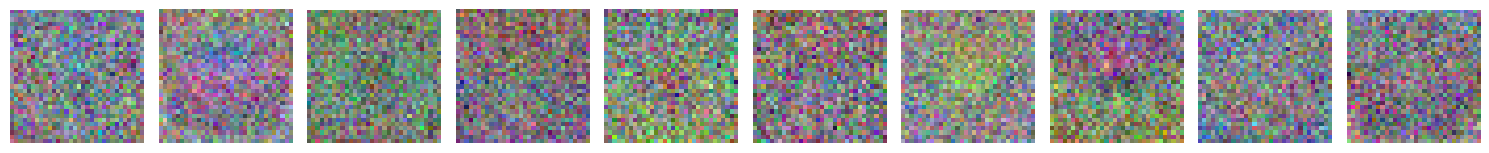


Plot loss and accuracy...


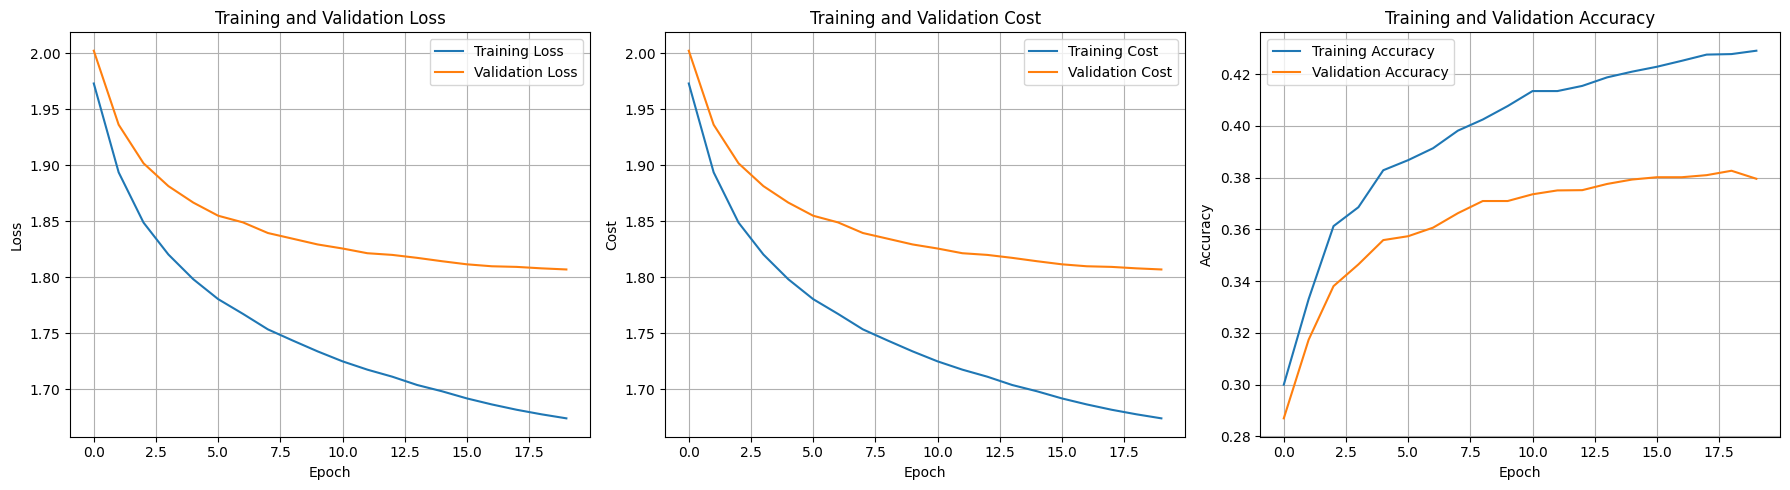

In [36]:
def test_experiment1():
    GDparams = {"n_batch": 100, "eta": 0.001, "n_epochs": 20, "lam": 0}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("initial_experiments", GDparams, rng)


test_experiment1()

Run experiment...
lambda: 0
number of epochs: 40
batch size: 100
learning rate: 0.001

Train neural network...
Epoch 1/40 | Training Loss: 1.9729 | Validation Loss: 2.0021 | Training Cost: 1.9729 | Validation Cost: 2.0021 | Training Accuracy: 0.3000 | Validation Accuracy: 0.2870
Epoch 2/40 | Training Loss: 1.8936 | Validation Loss: 1.9361 | Training Cost: 1.8936 | Validation Cost: 1.9361 | Training Accuracy: 0.3331 | Validation Accuracy: 0.3174
Epoch 3/40 | Training Loss: 1.8488 | Validation Loss: 1.9017 | Training Cost: 1.8488 | Validation Cost: 1.9017 | Training Accuracy: 0.3613 | Validation Accuracy: 0.3381
Epoch 4/40 | Training Loss: 1.8203 | Validation Loss: 1.8813 | Training Cost: 1.8203 | Validation Cost: 1.8813 | Training Accuracy: 0.3686 | Validation Accuracy: 0.3465
Epoch 5/40 | Training Loss: 1.7982 | Validation Loss: 1.8666 | Training Cost: 1.7982 | Validation Cost: 1.8666 | Training Accuracy: 0.3829 | Validation Accuracy: 0.3559
Epoch 6/40 | Training Loss: 1.7805 | Validat

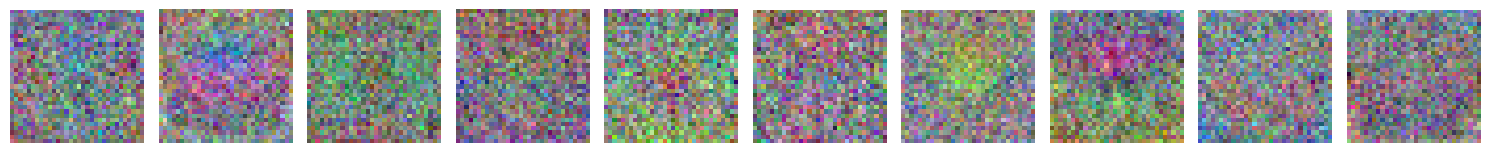


Plot loss and accuracy...


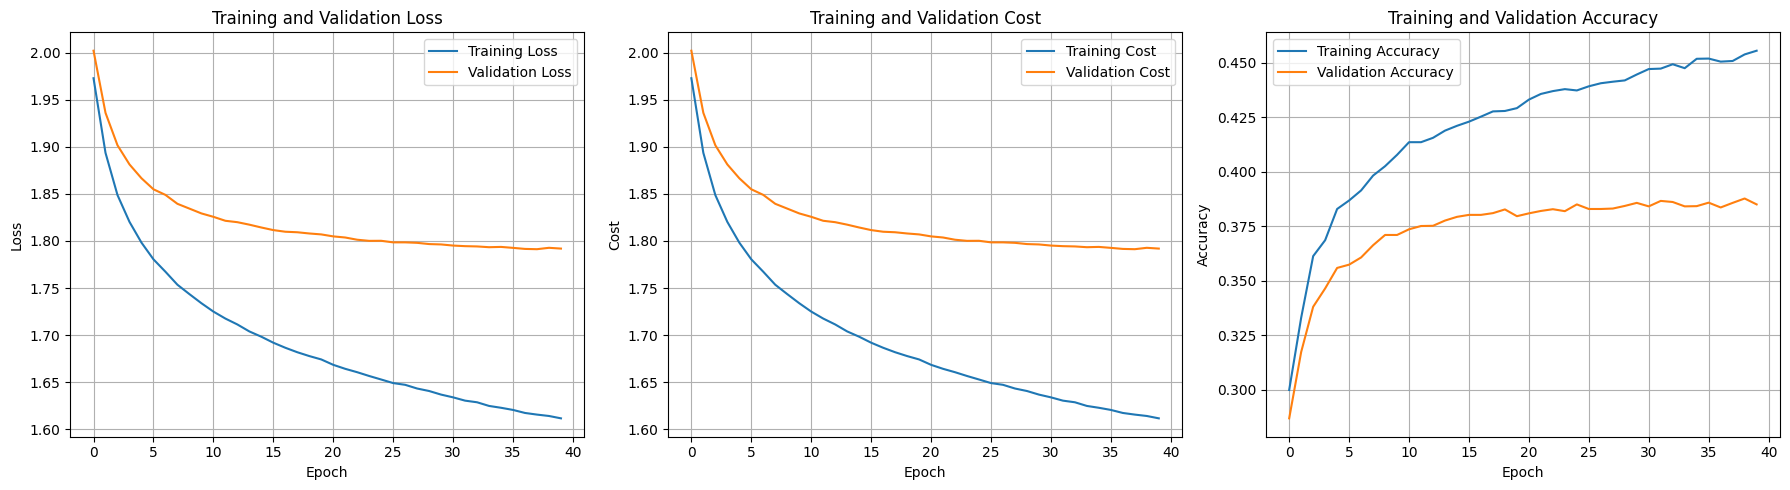

In [37]:
def test_experiment2():
    GDparams = {"n_batch": 100, "eta": 0.001, "n_epochs": 40, "lam": 0}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("initial_experiments_2", GDparams, rng)
    
test_experiment2()

### Experiments

Run experiment...
lambda: 0
number of epochs: 40
batch size: 100
learning rate: 0.1

Train neural network...
Epoch 1/40 | Training Loss: 7.9115 | Validation Loss: 8.2522 | Training Cost: 7.9115 | Validation Cost: 8.2522 | Training Accuracy: 0.2672 | Validation Accuracy: 0.2397
Epoch 2/40 | Training Loss: 7.2659 | Validation Loss: 7.9464 | Training Cost: 7.2659 | Validation Cost: 7.9464 | Training Accuracy: 0.2955 | Validation Accuracy: 0.2573
Epoch 3/40 | Training Loss: 4.3020 | Validation Loss: 5.1067 | Training Cost: 4.3020 | Validation Cost: 5.1067 | Training Accuracy: 0.3366 | Validation Accuracy: 0.2783
Epoch 4/40 | Training Loss: 4.1414 | Validation Loss: 5.0486 | Training Cost: 4.1414 | Validation Cost: 5.0486 | Training Accuracy: 0.3662 | Validation Accuracy: 0.2983
Epoch 5/40 | Training Loss: 4.8951 | Validation Loss: 5.8777 | Training Cost: 4.8951 | Validation Cost: 5.8777 | Training Accuracy: 0.3443 | Validation Accuracy: 0.2769
Epoch 6/40 | Training Loss: 4.5599 | Validatio

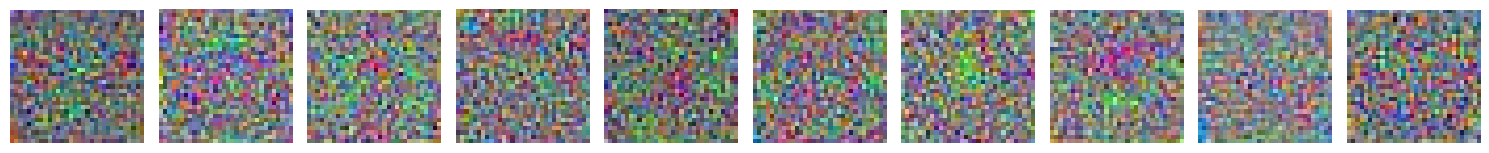


Plot loss and accuracy...


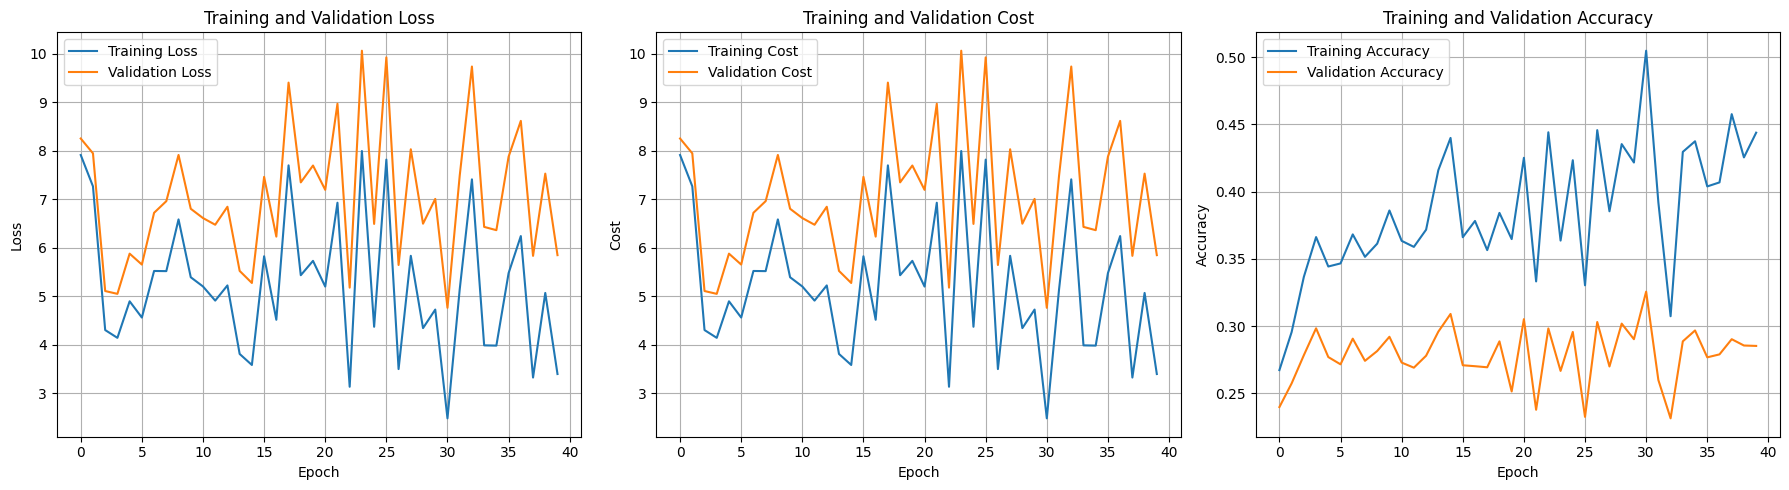

In [38]:
def experiment1():
    GDparams = {"lam": 0, "n_epochs": 40, "n_batch": 100, "eta": 0.1}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("experiment_1", GDparams, rng)


experiment1()

Run experiment...
lambda: 0
number of epochs: 40
batch size: 100
learning rate: 0.001

Train neural network...
Epoch 1/40 | Training Loss: 1.9729 | Validation Loss: 2.0021 | Training Cost: 1.9729 | Validation Cost: 2.0021 | Training Accuracy: 0.3000 | Validation Accuracy: 0.2870
Epoch 2/40 | Training Loss: 1.8936 | Validation Loss: 1.9361 | Training Cost: 1.8936 | Validation Cost: 1.9361 | Training Accuracy: 0.3331 | Validation Accuracy: 0.3174
Epoch 3/40 | Training Loss: 1.8488 | Validation Loss: 1.9017 | Training Cost: 1.8488 | Validation Cost: 1.9017 | Training Accuracy: 0.3613 | Validation Accuracy: 0.3381
Epoch 4/40 | Training Loss: 1.8203 | Validation Loss: 1.8813 | Training Cost: 1.8203 | Validation Cost: 1.8813 | Training Accuracy: 0.3686 | Validation Accuracy: 0.3465
Epoch 5/40 | Training Loss: 1.7982 | Validation Loss: 1.8666 | Training Cost: 1.7982 | Validation Cost: 1.8666 | Training Accuracy: 0.3829 | Validation Accuracy: 0.3559
Epoch 6/40 | Training Loss: 1.7805 | Validat

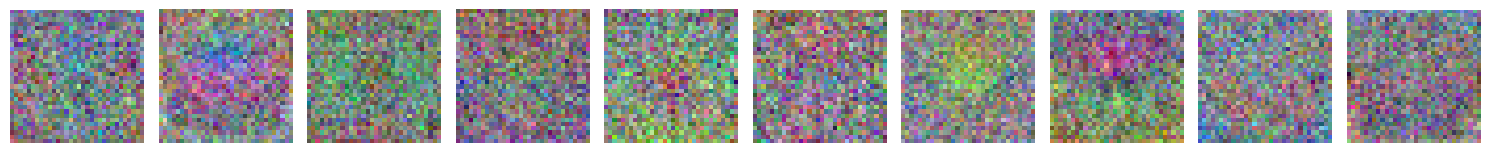


Plot loss and accuracy...


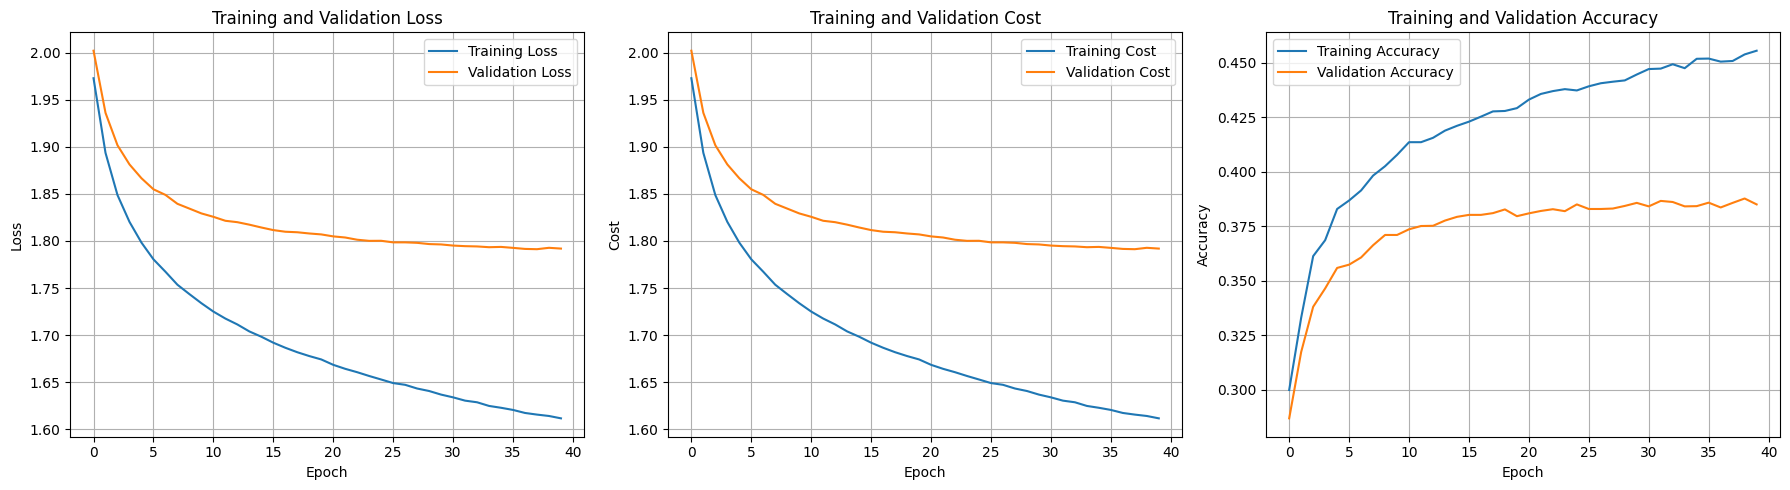

In [39]:
def experiment2():
    GDparams = {"lam": 0, "n_epochs": 40, "n_batch": 100, "eta": 0.001}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("experiment_2", GDparams, rng)


experiment2()

Run experiment...
lambda: 0.1
number of epochs: 40
batch size: 100
learning rate: 0.001

Train neural network...
Epoch 1/40 | Training Loss: 1.9726 | Validation Loss: 2.0016 | Training Cost: 2.2707 | Validation Cost: 2.2997 | Training Accuracy: 0.3007 | Validation Accuracy: 0.2876
Epoch 2/40 | Training Loss: 1.8936 | Validation Loss: 1.9355 | Training Cost: 2.1816 | Validation Cost: 2.2235 | Training Accuracy: 0.3346 | Validation Accuracy: 0.3180
Epoch 3/40 | Training Loss: 1.8493 | Validation Loss: 1.9010 | Training Cost: 2.1278 | Validation Cost: 2.1795 | Training Accuracy: 0.3616 | Validation Accuracy: 0.3389
Epoch 4/40 | Training Loss: 1.8213 | Validation Loss: 1.8806 | Training Cost: 2.0908 | Validation Cost: 2.1501 | Training Accuracy: 0.3693 | Validation Accuracy: 0.3482
Epoch 5/40 | Training Loss: 1.7999 | Validation Loss: 1.8658 | Training Cost: 2.0608 | Validation Cost: 2.1267 | Training Accuracy: 0.3843 | Validation Accuracy: 0.3563
Epoch 6/40 | Training Loss: 1.7828 | Valid

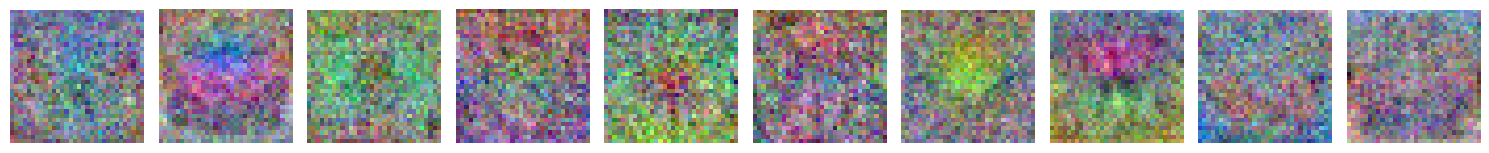


Plot loss and accuracy...


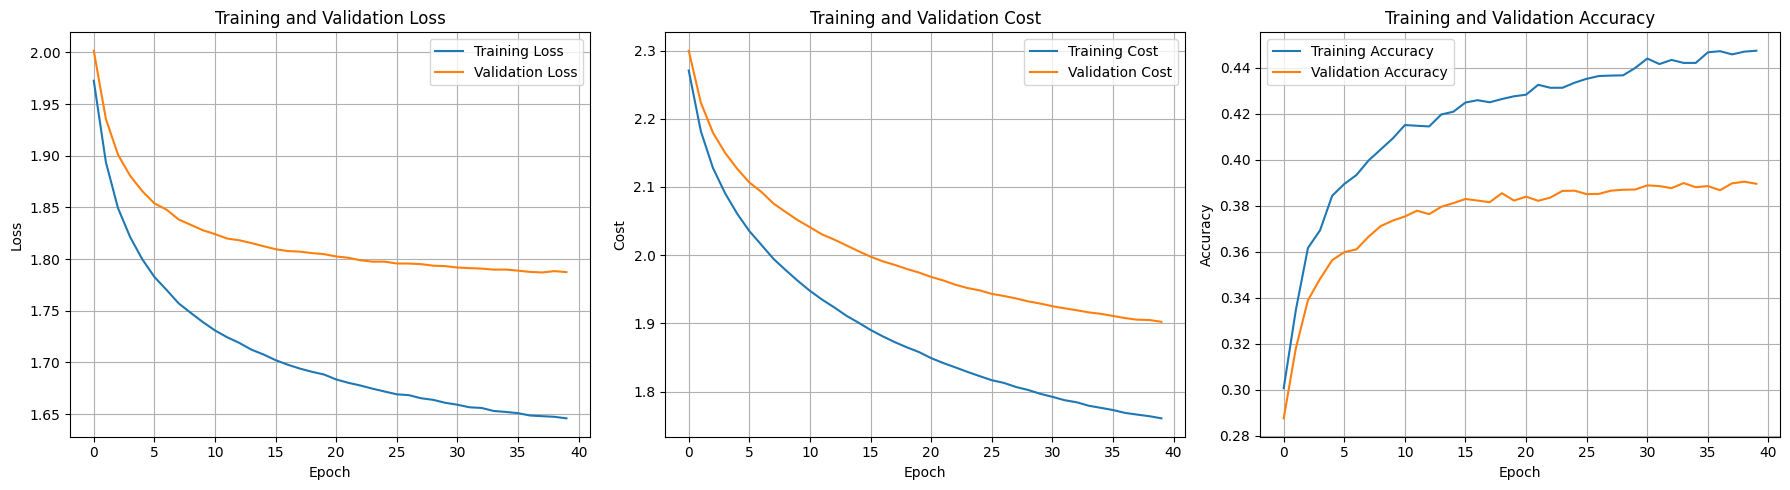

In [40]:
def experiment3():
    GDparams = {"lam": 0.1, "n_epochs": 40, "n_batch": 100, "eta": 0.001}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("experiment_3", GDparams, rng)


experiment3()

Run experiment...
lambda: 1.0
number of epochs: 40
batch size: 100
learning rate: 0.001

Train neural network...
Epoch 1/40 | Training Loss: 1.9723 | Validation Loss: 1.9996 | Training Cost: 4.0557 | Validation Cost: 4.0831 | Training Accuracy: 0.3030 | Validation Accuracy: 0.2907
Epoch 2/40 | Training Loss: 1.9011 | Validation Loss: 1.9381 | Training Cost: 3.3173 | Validation Cost: 3.3543 | Training Accuracy: 0.3391 | Validation Accuracy: 0.3224
Epoch 3/40 | Training Loss: 1.8655 | Validation Loss: 1.9086 | Training Cost: 2.8390 | Validation Cost: 2.8821 | Training Accuracy: 0.3650 | Validation Accuracy: 0.3437
Epoch 4/40 | Training Loss: 1.8467 | Validation Loss: 1.8937 | Training Cost: 2.5255 | Validation Cost: 2.5725 | Training Accuracy: 0.3702 | Validation Accuracy: 0.3481
Epoch 5/40 | Training Loss: 1.8343 | Validation Loss: 1.8841 | Training Cost: 2.3170 | Validation Cost: 2.3668 | Training Accuracy: 0.3838 | Validation Accuracy: 0.3574
Epoch 6/40 | Training Loss: 1.8257 | Valid

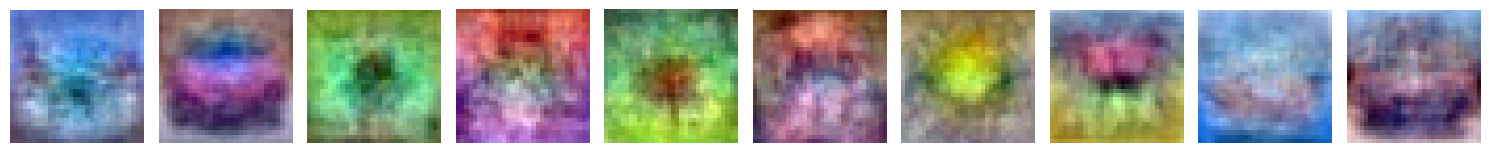


Plot loss and accuracy...


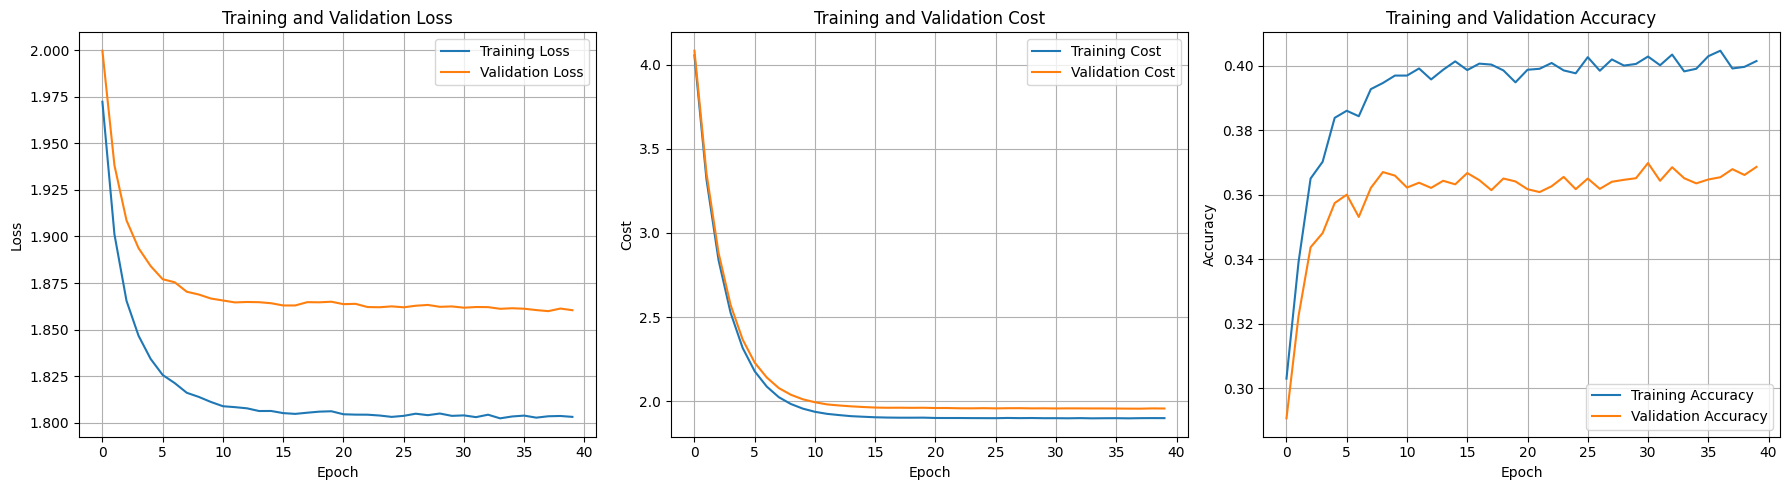

In [41]:
def experiment4():
    GDparams = {"lam": 1.0, "n_epochs": 40, "n_batch": 100, "eta": 0.001}
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)
    run_experiments("experiment_4", GDparams, rng)


experiment4()